<a href="https://colab.research.google.com/github/akshit61/Projects/blob/master/Object_detection/Helmet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    },
    'ssd_mobilenetv2_oidv4': {
        'model_name': 'ssd_mobilenet_v2_oid_v4_2018_12_12',
        'pipeline_file': 'ssd_mobilenet_v2_oid_v4.config',
    }
}

# Select a model in `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

In [0]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 31kB/s 
     |████████████████████████████████| 3.8MB 51.1MB/s 
     |████████████████████████████████| 512kB 47.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=89d412142fd721a2e4bd8b56532b67ec070fec4fda066b97e9ebfbded5aa80eb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninsta

In [0]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -qq Cython contextlib2 pillow lxml matplotlib

!pip install -qq pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [0]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict

import shutil
import urllib.request
import tarfile
from matplotlib import pyplot as plt
from google.colab import files

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
#we need tenorflow v 1.13.2, object detection API is removed from tf v 2.0+
print(tf.__version__)

1.15.0


In [0]:
cd '/content/drive/My Drive/OID'

/content/drive/My Drive/OID


In [0]:
!git clone --q https://github.com/zamblauskas/oidv4-toolkit-tfrecord-generator.git

fatal: destination path 'oidv4-toolkit-tfrecord-generator' already exists and is not an empty directory.


In [0]:
# Downlaods Tenorflow
%cd /content/drive/My Drive/OID
!git clone --q https://github.com/tensorflow/models.git

/content/drive/My Drive/OID


In [0]:
%cd /content/drive/My Drive/OID/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/OID/models/research:/content/drive/My Drive/OID/models/research/slim/'

/content/drive/My Drive/OID/models/research


In [0]:
# testing the model builder
!python3 object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

In [0]:
%cd '/content/drive/My Drive/OID/Dataset'

label_map_path = os.path.join("label_map.pbtxt")

pbtxt_content = ""

#creats a pbtxt file the has the class names.
pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: 'Helmet'\n }}\n\n".format(1, 'Helmet')
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

/content/drive/My Drive/OID/Dataset


In [0]:
!cat label_map.pbtxt

item {
    id: 1
    name: 'Helmet'
    display_name: 'Helmet'
 }

In [0]:
os.getcwd()

'/content/drive/My Drive/OID'

In [0]:
%cd '/content/drive/My Drive/OID'

/content/drive/My Drive/OID


In [0]:
!python oidv4-toolkit-tfrecord-generator/generate_tfrecord.py \
  --classes_file=classes.txt \
  --class_descriptions_file=csv_folder/class-descriptions-boxable.csv \
  --annotations_file=csv_folder/train-annotations-bbox.csv \
  --images_dir=Dataset/train \
  --output_file=Dataset/train.tfrecord


Classes: {'Helmet': 1}

W0429 07:54:46.760086 139944044189568 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:32: The name tf.gfile.Glob is deprecated. Please use tf.io.gfile.glob instead.

700 images

W0429 07:54:46.977640 139944044189568 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:37: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0429 07:54:47.881448 139944044189568 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:40: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

......................................................................................................................................................................................................................................................................................................................................................

In [0]:
!python oidv4-toolkit-tfrecord-generator/generate_tfrecord.py \
  --classes_file=classes.txt \
  --class_descriptions_file=csv_folder/class-descriptions-boxable.csv \
  --annotations_file=csv_folder/validation-annotations-bbox.csv \
  --images_dir=Dataset/validation \
  --output_file=Dataset/validation.tfrecord


Classes: {'Helmet': 1}

W0428 17:53:35.887696 139982705723264 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:32: The name tf.gfile.Glob is deprecated. Please use tf.io.gfile.glob instead.

274 images

W0428 17:53:41.209374 139982705723264 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:37: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0428 17:53:45.927180 139982705723264 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate_tfrecord.py:40: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

.................................................................................................................................................................................................................................................................................. done


In [0]:
%cd /content/drive/My Drive/OID/models/research

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/drive/My Drive/OID/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/drive/My Drive/OID/models/research


In [0]:
#checking the content of the pretrained model.
# this is the directory of the "fine_tune_checkpoint" that is used in the config file.
!echo {fine_tune_dir}
!ls -alh {'/content/drive/My\ Drive/OID/models/research/pretrained_model'}

/content/drive/My Drive/OID/models/research/pretrained_model
total 131M
-rw------- 1 root root   77 Dec 12  2018 checkpoint
-rw------- 1 root root  64M Dec 12  2018 frozen_inference_graph.pb
-rw------- 1 root root  56M Dec 12  2018 model.ckpt.data-00000-of-00001
-rw------- 1 root root  14K Dec 12  2018 model.ckpt.index
-rw------- 1 root root  12M Dec 12  2018 model.ckpt.meta
-rw------- 1 root root 4.2K Dec 12  2018 pipeline.config
drwx------ 3 root root 4.0K Dec 12  2018 saved_model


In [0]:
#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/drive/My\ Drive/OID/models/research/object_detection/samples/configs/"

#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)

In [0]:
%cd '/content/drive/My Drive/OID/models/research/object_detection/samples/configs/'

/content/drive/My Drive/OID/models/research/object_detection/samples/configs


In [0]:
%%writefile {pipeline_file}
model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.0008
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  gradient_clipping_by_norm: 10.0
  keep_checkpoint_every_n_hours: 24
  fine_tune_checkpoint: "/content/drive/My Drive/OID/models/research/pretrained_model/model.ckpt"
  num_steps: 10000000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/OID/Dataset/train.record"
  }
  label_map_path: "/content/drive/My Drive/OID/Dataset/label_map.pbtxt"
}

eval_config: {
  metrics_set: "open_images_V2_detection_metrics"
}

eval_input_reader: {
  sample_1_of_n_examples: 10
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/OID/Dataset/validation.tfrecord"
  }
  label_map_path: "content/drive/My Drive/OID/Dataset/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}



Overwriting ssd_mobilenet_v2_oid_v4.config


In [0]:
#editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

%%writefile {pipeline_file}
#%%writefile /content/drive/My\ Drive/OID/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    # all images will be resized to the below W x H.
    image_resizer { 
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        #use_dropout: false
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000 
        iou_threshold: 0.95
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        
        #adjust this to the max number of objects per class. 
        # ex, in my case, i have one pistol in most of the images.
        # . there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 16
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 16 # training batch size
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.003
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }

  #the path to the pretrained model. 
  fine_tune_checkpoint: "/content/drive/My Drive/OID/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000 
  

  #data augmentaion is done here, you can remove or add more.
  # They will help the model generalize but the training time will increase greatly by using more data augmentation.
  # Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
  
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/content/drive/My Drive/OID/Dataset/train.tfrecord"
  }
  #path to the label map 
  label_map_path: "/content/drive/My Drive/OID/Dataset/label_map.pbtxt"
}

eval_config: {
  # the number of images in your "testing" data (was 600 but we removed one above :) )
  num_examples: 599
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20

  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
      
    #path to the testing TFRecord
    input_path: "/content/drive/My Drive/OID/Dataset/validation.tfrecord"
  }
  #path to the label map 
  label_map_path: "/content/drive/My Drive/OID/Dataset/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting ssd_mobilenet_v2_coco.config


In [0]:
%cd '/content/drive/My Drive/OID/models/research'

/content/drive/My Drive/OID/models/research


In [0]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [0]:
#downlaoding ngrok to be able to access tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-04-29 10:42:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.42.118, 52.5.232.178, 3.213.66.77, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.42.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  12.6MB/s    in 1.0s    

2020-04-29 10:43:00 (12.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
#the logs that are created while training 
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://35c4cc4a.ngrok.io


In [0]:
!python3 ./object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0429 10:45:46.017649 139945429706624 module_wrapper.py:139] From /content/drive/My Drive/OID/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0429 10:45:46.022624 139945429706624 module_wrapper.py:139] From /content/drive/My Drive/OID/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0429 10:45:46.022784 139945429706624 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0429 10:45:46.022905 139945429706624 module_wrap

In [0]:


#the location where the exported model will be saved in.
output_directory = '/content/drive/My\ Drive/OID/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python ./object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-952
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0428 18:56:36.442108 140168529115008 module_wrapper.py:139] From ./object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0428 18:56:36.449788 140168529115008 module_wrapper.py:139] From /content/drive/My Drive/OID/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0428 18:56:36.452095 140168529115008 module_wrapper.py:139] From /content/drive/My Drive/OID/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Ple

In [0]:
from distutils.version import StrictVersion
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
cd '/content/drive/My Drive/OID/models/research/object_detection'

/content/drive/My Drive/OID/models/research/object_detection


In [0]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [0]:
MODEL_NAME = '/content/drive/My Drive/OID/models/research/fine_tuned_model'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/OID/Dataset', 'label_map.pbtxt')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/OID/Dataset/test/Helmet'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'.format(i)) for i in range(1, 3) ]
image_list =[f for f in  os.listdir(PATH_TO_TEST_IMAGES_DIR)]
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR,image) for image in image_list[4:7]] 
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['/content/drive/My Drive/OID/Dataset/test/Helmet/63373c02c7203e5b.jpg', '/content/drive/My Drive/OID/Dataset/test/Helmet/636f1687e51c4768.jpg', '/content/drive/My Drive/OID/Dataset/test/Helmet/63ba82a9b52b20da.jpg']


In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

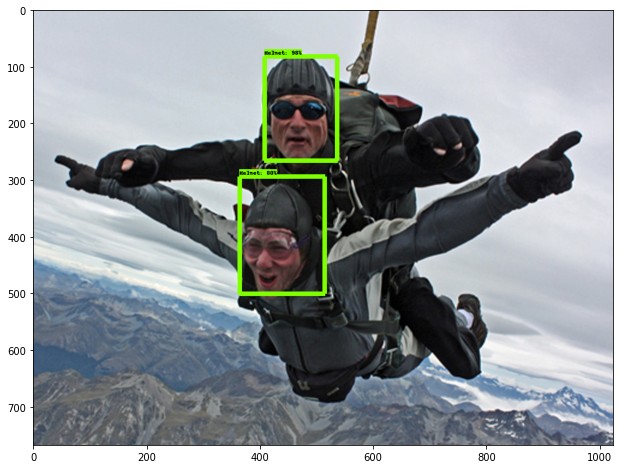

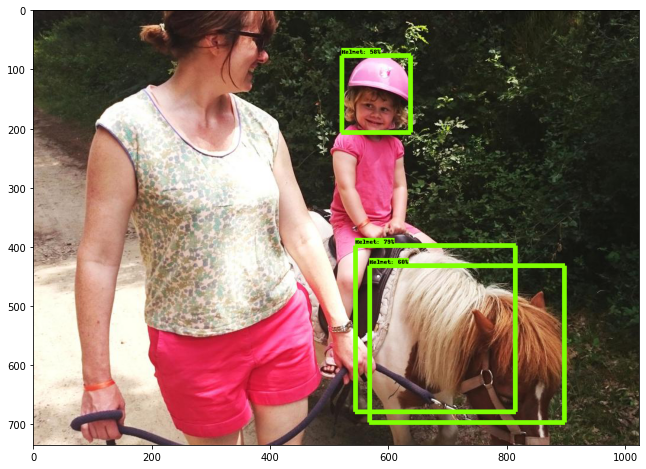

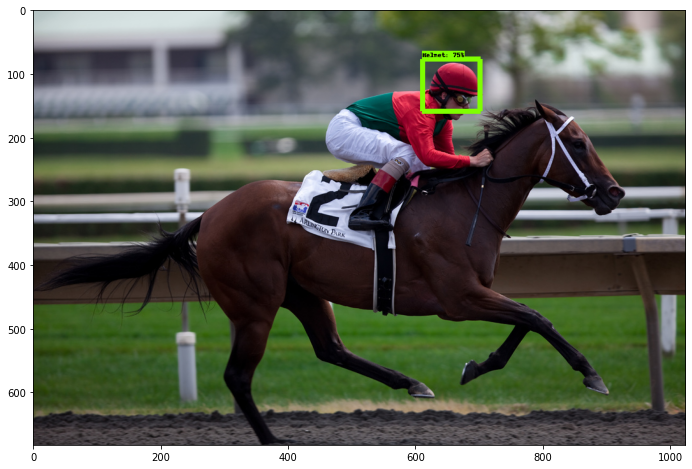

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)